# 07: PyTorch Experiment Tracking

This notebook tries several different models with different types of data augmentation and tracks the results to compare them.

## TODO:
* Setup different experiments
* Track different experiments with SummaryWriter/PyTorch profiler (can view these on Weights & Biases)
    * 1. EffNetB0 + no augmentation
    * 2. EffNetB0 + random augmentation
    * 3. EffNetB4 + no augmentation
    * 4. EffNetB4 + random augmentation
    * Mixed precision?

* See here for more on the profiler: https://pytorch.org/blog/introducing-pytorch-profiler-the-new-and-improved-performance-tool/
* See here on setting up TensorBoard in VSCode: https://code.visualstudio.com/docs/datascience/pytorch-support

Start with one model + tracking experiments, then upgrade to more.

In [7]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

from going_modular import data_setup, engine

## Setup device

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get and load data

In [3]:
import os
import requests
from zipfile import ZipFile

def get_food_image_data():
    if not os.path.exists("data/10_whole_foods"):
        os.makedirs("data/", exist_ok=True)
        # Download data
        data_url = "https://storage.googleapis.com/food-vision-image-playground/10_whole_foods.zip"
        print(f"Downloading data from {data_url}...")
        requests.get(data_url)
        # Unzip data
        targ_dir = "data/10_whole_foods"
        print(f"Extracting data to {targ_dir}...")
        with ZipFile("10_whole_foods.zip") as zip_ref:
            zip_ref.extractall(targ_dir)
    else:
        print("data/10_whole_foods dir exists, skipping download")

get_food_image_data()

data/10_whole_foods dir exists, skipping download


In [12]:
# Setup dirs
train_dir = "data/10_whole_foods/train"
test_dir = "data/10_whole_foods/test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create starter transform
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f62f6cb4850>,
 ['apple',
  'banana',
  'beef',
  'blueberries',
  'carrots',
  'chicken_wings',
  'egg',
  'honey',
  'mushrooms',
  'strawberries'])

## Load model 

In [36]:
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [37]:
# Update the classifier
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1280, len(class_names)).to(device))

# Freeze all base layers 
for param in model.features.parameters():
    param.requires_grad = False

## Train model and track results

In [26]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Adjust training function to track results with `SummaryWriter`

In [32]:
model.name = "EfficietNetB0"
model.name

'EfficietNetB0'

In [79]:
from torch.utils.tensorboard import SummaryWriter
from going_modular.engine import train_step, test_step
from tqdm import tqdm
writer = SummaryWriter()

In [78]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    epochs=5,
):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Add results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
    
    # Close the writer
    writer.close()

    return results

In [29]:
# Train model
# Note: Not using engine.train() since the original script isn't updated
results = train(model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=5)

 20%|██        | 1/5 [00:01<00:07,  1.91s/it]

Epoch: 1 | train_loss: 0.2990 | train_acc: 0.9381 | test_loss: 0.4921 | test_acc: 0.8229


 40%|████      | 2/5 [00:03<00:05,  1.95s/it]

Epoch: 2 | train_loss: 0.2319 | train_acc: 0.9713 | test_loss: 0.5957 | test_acc: 0.8021


 60%|██████    | 3/5 [00:05<00:03,  1.93s/it]

Epoch: 3 | train_loss: 0.2114 | train_acc: 0.9679 | test_loss: 0.3841 | test_acc: 0.8698


 80%|████████  | 4/5 [00:07<00:01,  1.92s/it]

Epoch: 4 | train_loss: 0.1943 | train_acc: 0.9728 | test_loss: 0.5046 | test_acc: 0.8333


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]

Epoch: 5 | train_loss: 0.1818 | train_acc: 0.9649 | test_loss: 0.4839 | test_acc: 0.8333


## Create a helper function to build `SummaryWriter()`(s)

In [71]:
from torchvision.models import efficientnet_b4
effnetb4_in_features = 1792

In [72]:
effnetb4 = efficientnet_b4(pretrained=True).to(device)
effnetb4

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

In [73]:
for param in effnetb4.features.parameters():
    param.requires_grad = False


In [74]:
effnetb4.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features=1792, out_features=len(class_names))
).to(device)

In [76]:
def create_writer(experiment_name, model_name, extra=None):
    assert experiment_name, "experiment_name can't be None"
    assert model_name, "model_name can't be None"

    if extra:
        log_dir = os.path.join("runs", experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", experiment_name, model_name)
    print(f"Created SummaryWriter and saving to {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [81]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    epochs=5,
    writer=None
):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                            tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                            global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                            tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                            global_step=epoch)
        else:
            pass
    
    if writer:
        # Close the writer
        writer.close()

    return results

## Setup a series of modelling experiments

In [77]:
optimizer = torch.optim.Adam(params=effnetb4.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1) # label smoothing from here: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [79]:
results = train(model=effnetb4,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    writer=create_writer(experiment_name="no_data_augmentation", model_name="effnetb4", extra="label_smoothing")
)

Created SummaryWriter and saving to no_data_augmentation/effnetb4/label_smoothing...


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

Epoch: 1 | train_loss: 1.2164 | train_acc: 0.8461 | test_loss: 1.3528 | test_acc: 0.7344


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

Epoch: 2 | train_loss: 1.1285 | train_acc: 0.8663 | test_loss: 1.2134 | test_acc: 0.8594


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

Epoch: 3 | train_loss: 1.0807 | train_acc: 0.8741 | test_loss: 1.1759 | test_acc: 0.8542


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

Epoch: 4 | train_loss: 1.0105 | train_acc: 0.8890 | test_loss: 1.1328 | test_acc: 0.8229


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

Epoch: 5 | train_loss: 0.9681 | train_acc: 0.8890 | test_loss: 1.0863 | test_acc: 0.8542


## TODO: Experiment creation

Want:
* A list or dict of different models and experiments to run
* Each experiment should run only changing the model or augmentation type 
    * e.g. Experiment 1: model = EffNetB0, aug = None 
    * Experiment 2: model = EffNetB4, aug = None 

See a list of Torch pretrained models here: https://pytorch.org/vision/stable/models.html, all pretrained models are expected to have data inputs that are normalized with the following:
```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```                                


In [9]:
# Setup dirs
train_dir = "data/10_whole_foods/train"
test_dir = "data/10_whole_foods/test"

In [14]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

### Load data

TK - Note: have to update this to handle different transforms for each dataset (e.g. train/test)

In [15]:
import os
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, 
    test_transform, 
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [16]:
train_dataloader_aug, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=train_transform_data_aug,
    test_transform=simple_transform,
    batch_size=32,
    num_workers=NUM_WORKERS
)

train_dataloader_no_aug, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=simple_transform,
    test_transform=simple_transform,
    batch_size=32,
    num_workers=NUM_WORKERS
)

### Visualize manipulated data

In [54]:
imgs, labels = next(iter(train_dataloader_aug))
imgs.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Augmented data

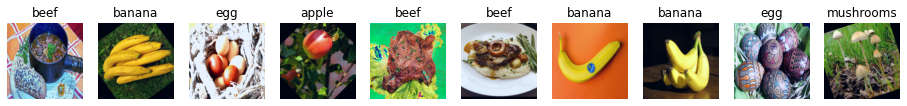

In [67]:
imgs, labels = next(iter(train_dataloader_aug))
plt.figure(figsize=(16, 8))
for i in range(10):
    # Min max scale the image for display purposes
    targ_image = imgs[i]
    sample_min, sample_max = targ_image.min(), targ_image.max()
    sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)
    plt.subplot(1, 10, i+1)
    plt.imshow(sample_scaled.permute(1, 2, 0))
    plt.title(class_names[labels[i]])
    plt.axis(False)
    # for i in range(10):
    #     plt.subplot(1, 10, i+1)
    #     plt.imshow(imgs[0][i].permute(1, 2, 0))
    #     plt.title(class_names[imgs[1][i]])

### Non-augmented data

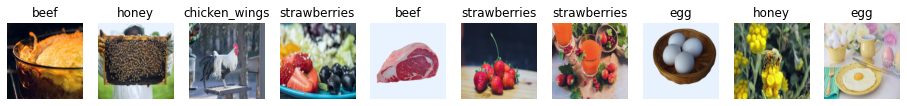

In [65]:
imgs, labels = next(iter(train_dataloader_no_aug))
plt.figure(figsize=(16, 8))
for i in range(10):
    # Min max scale the image for display purposes
    targ_image = imgs[i]
    sample_min, sample_max = targ_image.min(), targ_image.max()
    sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)
    plt.subplot(1, 10, i+1)
    plt.imshow(sample_scaled.permute(1, 2, 0))
    plt.title(class_names[labels[i]])
    plt.axis(False)

## Setup models

In [68]:
import torchvision
from torch import nn

# Get num out features
OUT_FEATURES = len(class_names)

# EfficientNetB0
effnetb0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=OUT_FEATURES)
).to(device)
for param in effnetb0.features.parameters():
    param.requires_grad = False

# EfficientNetB4
effnetb4 = torchvision.models.efficientnet_b4(pretrained=True).to(device)
effnetb4.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features=1792, out_features=OUT_FEATURES)
).to(device)
for param in effnetb4.features.parameters():
    param.requires_grad = False


## Create experiments

In [72]:
models = {"effnetb0": effnetb0,
          "effnetb4" : effnetb4}
train_dataloaders = {"data_aug": train_dataloader_aug,
                     "data_no_aug": train_dataloader_no_aug}

In [82]:
for model_name, model in models.items():
    for dataloader_name, train_dataloader in train_dataloaders.items():
        print(f"Model: {model_name}, Dataloader: {dataloader_name}")
        # Train each model with experiment tracking
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
        
        # Print out progress
        print(f"\nTraining model {model_name} with dataloder: {dataloader_name}...")
        print(f"----------")        

        train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader, 
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=5,
             writer=create_writer(experiment_name=dataloader_name,
                model_name=model_name
             ))

Model: effnetb0, Dataloader: data_aug

Training model effnetb0 with dataloder: data_aug...
----------
Created SummaryWriter and saving to data_aug/effnetb0...


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

Epoch: 1 | train_loss: 1.9875 | train_acc: 0.3810 | test_loss: 1.5060 | test_acc: 0.8281


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

Epoch: 2 | train_loss: 1.3502 | train_acc: 0.7600 | test_loss: 1.0661 | test_acc: 0.8333


 60%|██████    | 3/5 [00:06<00:04,  2.06s/it]

Epoch: 3 | train_loss: 1.0317 | train_acc: 0.7970 | test_loss: 0.7835 | test_acc: 0.8750


 80%|████████  | 4/5 [00:08<00:02,  2.01s/it]

Epoch: 4 | train_loss: 0.8597 | train_acc: 0.8123 | test_loss: 0.7150 | test_acc: 0.9010


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Epoch: 5 | train_loss: 0.7369 | train_acc: 0.8529 | test_loss: 0.5824 | test_acc: 0.8854
Model: effnetb0, Dataloader: data_no_aug

Training model effnetb0 with dataloder: data_no_aug...
----------
Created SummaryWriter and saving to data_no_aug/effnetb0...


 20%|██        | 1/5 [00:01<00:07,  1.96s/it]

Epoch: 1 | train_loss: 0.5447 | train_acc: 0.8994 | test_loss: 0.5024 | test_acc: 0.8854


 40%|████      | 2/5 [00:03<00:05,  1.93s/it]

Epoch: 2 | train_loss: 0.4385 | train_acc: 0.9167 | test_loss: 0.4518 | test_acc: 0.8906


 60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

Epoch: 3 | train_loss: 0.3783 | train_acc: 0.9322 | test_loss: 0.4855 | test_acc: 0.8958


 80%|████████  | 4/5 [00:07<00:01,  1.90s/it]

Epoch: 4 | train_loss: 0.3392 | train_acc: 0.9345 | test_loss: 0.4737 | test_acc: 0.8646


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch: 5 | train_loss: 0.2858 | train_acc: 0.9405 | test_loss: 0.3797 | test_acc: 0.8906
Model: effnetb4, Dataloader: data_aug

Training model effnetb4 with dataloder: data_aug...
----------
Created SummaryWriter and saving to data_aug/effnetb4...


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

Epoch: 1 | train_loss: 2.1619 | train_acc: 0.4077 | test_loss: 1.9998 | test_acc: 0.7656


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

Epoch: 2 | train_loss: 1.8498 | train_acc: 0.7200 | test_loss: 1.7378 | test_acc: 0.7500


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

Epoch: 3 | train_loss: 1.6083 | train_acc: 0.7602 | test_loss: 1.5240 | test_acc: 0.8021


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

Epoch: 4 | train_loss: 1.4327 | train_acc: 0.7921 | test_loss: 1.3495 | test_acc: 0.8542


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch: 5 | train_loss: 1.2496 | train_acc: 0.8116 | test_loss: 1.1713 | test_acc: 0.8646
Model: effnetb4, Dataloader: data_no_aug

Training model effnetb4 with dataloder: data_no_aug...
----------
Created SummaryWriter and saving to data_no_aug/effnetb4...


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

Epoch: 1 | train_loss: 1.0395 | train_acc: 0.8542 | test_loss: 1.0813 | test_acc: 0.8438


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

Epoch: 2 | train_loss: 0.9259 | train_acc: 0.8686 | test_loss: 1.0001 | test_acc: 0.8542


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

Epoch: 3 | train_loss: 0.8296 | train_acc: 0.8750 | test_loss: 0.9463 | test_acc: 0.8177


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

Epoch: 4 | train_loss: 0.7536 | train_acc: 0.8690 | test_loss: 0.9032 | test_acc: 0.7656


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]

Epoch: 5 | train_loss: 0.6874 | train_acc: 0.8865 | test_loss: 0.8069 | test_acc: 0.8542


## TOD0: Create differnet series of experiments
* Each folder could be a different experiment type?
    * e.g. `runs/model_name/data_aug_strategy/...`
* Or each folder could contain a certain model with different parameters
    * e.g. `runs/model_name/1234_aug_strategy/...`
* Or each folder could contain the experiment style?
    * e.g. `runs/data_augmentation/model_name_strategy/...`
    * and `runs/no_augmentation/model_name/...`